In [1]:
import math
import random
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

from IPython.display import Image

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')
sns.set_palette("bright")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

C:\Users\ajthampi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Load Data

In [2]:
breast_cancer = load_breast_cancer()
print(breast_cancer['DESCR'])

Breast Cancer Wisconsin (Diagnostic) Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, field
        13 is Radius SE, field 23 is Worst Radius.

        

# Process Data

In [5]:
df_bc = pd.DataFrame(breast_cancer['data'], columns=breast_cancer['feature_names'])
df_bc['target'] = breast_cancer['target'] # target cancer type - malignant/benign (0/1)
df_bc['target'] = df_bc['target'].apply(lambda x: 1 if x == 0 else 0) # flip the labels so that 0: benign and 1: malignant
print(f'Dataset size: {df_bc.shape}')
df_bc.head()

Dataset size: (569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


In [6]:
df_bc['target'].value_counts() / len(df_bc) * 100

0    62.741652
1    37.258348
Name: target, dtype: float64

This means roughly 62.7% cases are benign and 37.3% are malignant.

In [7]:
# Split dataframe into train and test
df_train, df_test = train_test_split(df_bc, test_size=0.2, random_state=42, stratify=df_bc['target'])
df_train = df_train.reset_index()
df_test = df_test.reset_index()
print(f'Size of train set: {df_train.shape}')
print(f'Size of test set: {df_test.shape}')

Size of train set: (455, 32)
Size of test set: (114, 32)


In [8]:
# Check distribution of class labels in train set
df_train['target'].value_counts() / len(df_train) * 100

0    62.637363
1    37.362637
Name: target, dtype: float64

In [9]:
# Check distribution of class labels in test set
df_test['target'].value_counts() / len(df_test) * 100

0    63.157895
1    36.842105
Name: target, dtype: float64

In [10]:
# Distribution of train
df_train.describe()

,index,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,...,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,282.019780,14.166077,19.417692,92.215868,659.578242,0.095993,0.103835,0.089184,0.049015,0.181497,...,25.904879,107.860484,890.569231,0.132083,0.255529,0.275166,0.115491,0.291364,0.084124,0.373626
std,163.583284,3.579081,4.290653,24.717118,360.418686,0.014310,0.053910,0.081698,0.039686,0.027646,...,6.079532,34.176019,582.346181,0.023481,0.158400,0.212066,0.066844,0.063043,0.018169,0.484299
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.062510,0.019380,0.000000,0.000000,0.106000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,143.500000,11.710000,16.335000,75.235000,420.400000,0.085130,0.063735,0.029520,0.019685,0.162050,...,21.490000,84.135000,516.150000,0.114550,0.147750,0.119350,0.064075,0.251200,0.071365,0.000000
50%,281.000000,13.340000,18.900000,86.180000,546.400000,0.095240,0.092280,0.059400,0.033340,0.179900,...,25.480000,97.650000,683.400000,0.131100,0.216700,0.229800,0.101000,0.282300,0.080090,0.000000
75%,421.500000,15.935000,21.830000,104.500000,795.500000,0.104900,0.130350,0.132200,0.074075,0.195400,...,30.200000,127.000000,1122.500000,0.146600,0.338100,0.385700,0.162100,0.318700,0.092085,1.000000
max,567.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


In [11]:
# Distribution of test
df_test.describe()

,index,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,...,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000
mean,291.903509,13.972491,18.778596,90.983860,636.173684,0.097826,0.106361,0.087263,0.048538,0.179824,...,24.768596,104.869386,840.726316,0.133508,0.249218,0.260303,0.111076,0.284934,0.083236,0.368421
std,168.120951,3.305763,4.323369,22.629551,316.477632,0.012994,0.048354,0.071593,0.035218,0.026545,...,6.351908,31.236836,514.711990,0.020089,0.153599,0.194713,0.061247,0.056903,0.017687,0.484506
min,4.000000,7.760000,10.820000,47.920000,181.000000,0.052630,0.036140,0.000000,0.000000,0.116700,...,14.820000,56.650000,240.100000,0.084840,0.054450,0.000000,0.000000,0.165200,0.057370,0.000000
25%,132.250000,11.607500,15.722500,74.472500,413.225000,0.088752,0.069703,0.030828,0.021895,0.161525,...,19.602500,84.072500,511.000000,0.120700,0.144800,0.099862,0.065770,0.243425,0.071892,0.000000
50%,302.000000,13.430000,18.285000,86.680000,558.200000,0.098070,0.096700,0.070550,0.035055,0.176900,...,24.265000,98.575000,692.650000,0.134800,0.199550,0.218050,0.097630,0.281300,0.079365,0.000000
75%,439.500000,15.302500,21.190000,101.950000,715.400000,0.107225,0.131125,0.117975,0.069968,0.196700,...,28.647500,116.825000,966.325000,0.142775,0.343000,0.373850,0.160100,0.315025,0.091862,1.000000
max,568.000000,23.090000,32.470000,152.100000,1682.000000,0.127800,0.241300,0.317400,0.156200,0.274300,...,45.410000,211.500000,2782.000000,0.200600,0.932700,0.848800,0.254200,0.516600,0.144600,1.000000


# Baseline Models

1. Random classifier
2. Majority class classifier

In [12]:
random_cls_proba = [random.random() for _ in range(len(df_test))]

In [13]:
majority_class = df_train['target'].value_counts().index[0]

In [14]:
# Augment test dataframe with baseline model results
df_test['baseline_1_proba'] = random_cls_proba
df_test['baseline_1'] = df_test['baseline_1_proba'].apply(lambda x: 1 if x > 0.5 else 0)
df_test['baseline_2'] = majority_class

# Random Forest Classifier

In [15]:
print(f"Number of features: {len(breast_cancer['feature_names'])}")

Number of features: 30


In [16]:
X_train = df_train[breast_cancer['feature_names']]
X_test = df_test[breast_cancer['feature_names']]
y_train = df_train[['target']].values

In [25]:
# Perform grid search to determine 'optimum' hyperparameters
model_pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                                 ('pca', PCA(random_state=42)), 
                                 ('rf_cls', RandomForestClassifier(random_state=42, n_jobs=4))])

# n_components = [2, 4, 8, 10, 13] # round 1
# n_estimators = [10, 50, 100, 1000] # round 1
# criteria = ['gini', 'entropy'] # round 1
# max_depths = [None, 10, 100, 1000] # round 1

# n_components = [8, 9, ] # round 2
# n_estimators = np.arange(500, 1501, 100) # round 2
# criteria = ['entropy', ] # round 2
# max_depths = [10, ] # round 2

# n_components = [8, ] # round 3
# n_estimators = np.arange(100, 600, 50) # round 3
# criteria = ['entropy', ] # round 3
# max_depths = [10, ] # round 3

n_components = [8, ] # round 4
n_estimators = np.arange(130, 151, 1) # round 4
criteria = ['entropy', ] # round 4
max_depths = [10, ] # round 4

estimator  = GridSearchCV(model_pipeline, cv=5, n_jobs=4, verbose=5, param_grid=dict(
                                        pca__n_components=n_components,
                                        rf_cls__n_estimators=n_estimators,
                                        rf_cls__criterion=criteria,
                                        rf_cls__max_depth=max_depths))
estimator.fit(X_train, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   10.8s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   28.0s
[Parallel(n_jobs=4)]: Done 105 out of 105 | elapsed:   42.0s finished
C:\Users\ajthampi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('rf_cls', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
        ...stimators=10, n_jobs=4,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'pca__n_components': [8], 'rf_cls__n_estimators': array([130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150]), 'rf_cls__criterion': ['entropy'], 'rf_cls__max_depth': [10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=5)

In [26]:
# round 1: {'pca__n_components': 8, 'rf_cls__criterion': 'entropy', 'rf_cls__max_depth': 10, 'rf_cls__n_estimators': 1000}
# round 2: {'pca__n_components': 8, 'rf_cls__criterion': 'entropy', 'rf_cls__max_depth': 10, 'rf_cls__n_estimators': 500}
# round 3: {'pca__n_components': 8, 'rf_cls__criterion': 'entropy', 'rf_cls__max_depth': 10, 'rf_cls__n_estimators': 150}
# round 4: {'pca__n_components': 8, 'rf_cls__criterion': 'entropy', 'rf_cls__max_depth': 10, 'rf_cls__n_estimators': 135}
estimator.best_params_ 

{'pca__n_components': 8,
 'rf_cls__criterion': 'entropy',
 'rf_cls__max_depth': 10,
 'rf_cls__n_estimators': 135}

In [27]:
best_model = estimator.best_estimator_

In [28]:
y_test = best_model.predict(X_test)
y_proba_test = best_model.predict_proba(X_test)

In [29]:
df_test['rf_cls'] = y_test
df_test['rf_cls_proba'] = y_proba_test[:,1]

# Evaluate Model Performance

In [30]:
def normalise_cm(cm):
    return cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [31]:
def plot_confusion_matrix(cm, classes, filename,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = normalise_cm(cm)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(filename, dpi=200, bbox_inches='tight')

In [32]:
b1_cm = confusion_matrix(df_test['target'], df_test['baseline_1'])
b2_cm = confusion_matrix(df_test['target'], df_test['baseline_2'])
rf_cm = confusion_matrix(df_test['target'], df_test['rf_cls'])
b1_cm_norm = normalise_cm(b1_cm)
b2_cm_norm = normalise_cm(b2_cm)
rf_cm_norm = normalise_cm(rf_cm)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[ 1 -2]
 [-4  1]]


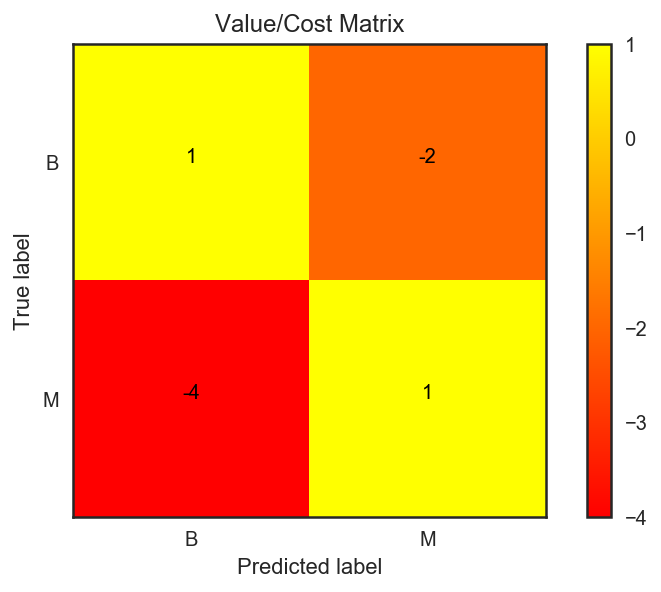

In [33]:
value_cost_matrix = np.array([[1, -2], [-4, 1]])
plot_confusion_matrix(value_cost_matrix, classes=['B', 'M'], 
                      filename='images/value_cost_matrix.png',
                      title='Value/Cost Matrix',
                      cmap=plt.cm.autumn)

Normalized confusion matrix
[[0.43 0.57]
 [0.4  0.6 ]]


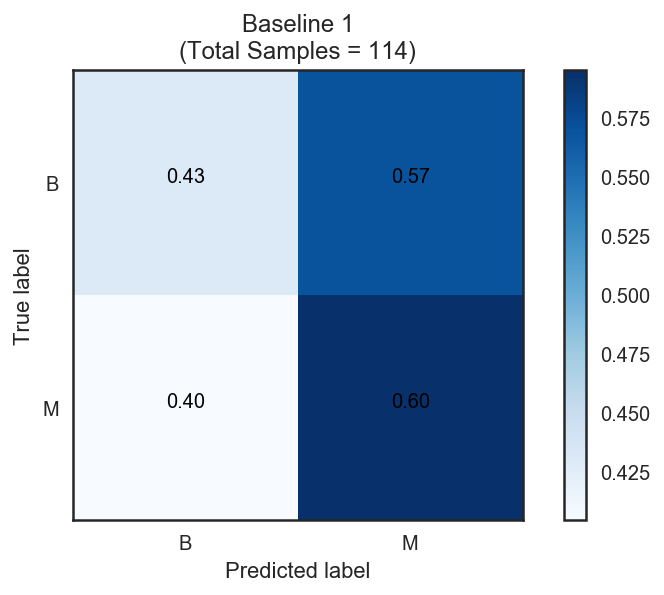

In [34]:
plot_confusion_matrix(b1_cm, classes=['B', 'M'], 
                      filename='images/baseline_1_cm.png',
                      title=f'Baseline 1\n(Total Samples = {len(df_test)})', 
                      normalize=True)

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


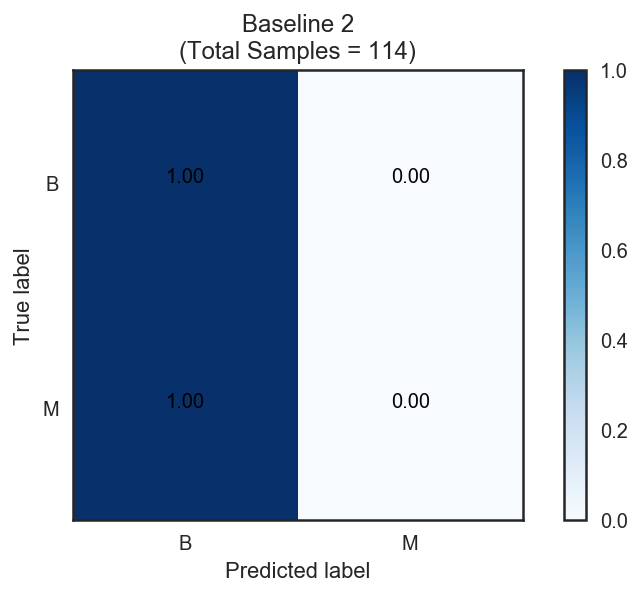

In [35]:
plot_confusion_matrix(b2_cm, classes=['B', 'M'], 
                      filename='images/baseline_2_cm.png',
                      title=f'Baseline 2\n(Total Samples = {len(df_test)})', 
                      normalize=True)

Normalized confusion matrix
[[0.97 0.03]
 [0.07 0.93]]


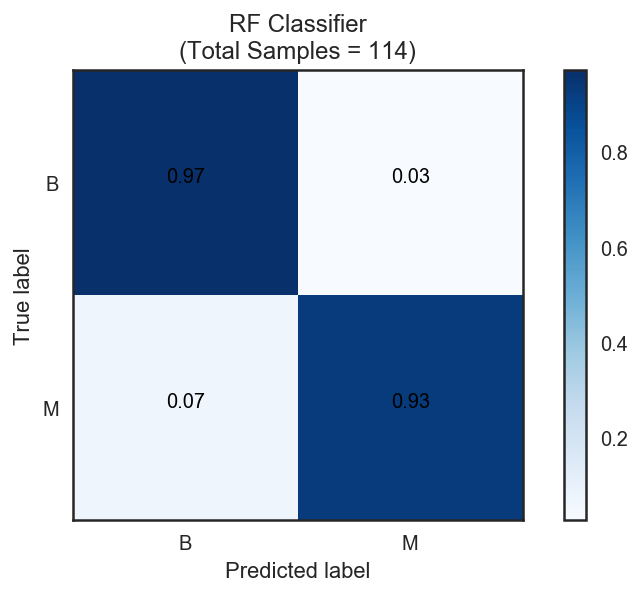

In [36]:
plot_confusion_matrix(rf_cm, classes=['B', 'M'], 
                      filename='images/rf_cls_cm.png',
                      title=f'RF Classifier\n(Total Samples = {len(df_test)})', 
                      normalize=True)

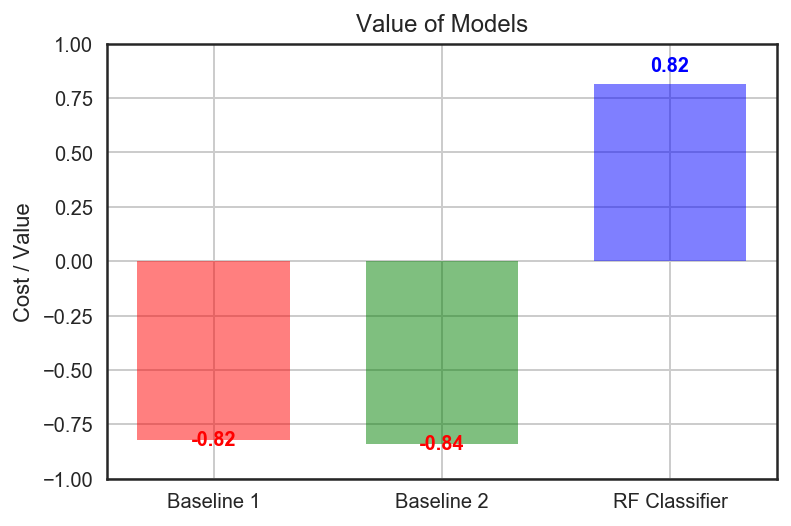

In [45]:
# Function to compute value given unnormalised confusion matrix (cm) and value-cost matrix (vcm)
compute_value = lambda cm, vcm: cm.flatten().dot(vcm.flatten()) / np.sum(cm)

b1_value = compute_value(b1_cm, value_cost_matrix)
b2_value = compute_value(b2_cm, value_cost_matrix)
rf_value = compute_value(rf_cm, value_cost_matrix)

f, ax = plt.subplots()
def autolabel(rect, color='blue'):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
            '%.2f' % height,
            ha='center', va='bottom', color=color, fontweight='bold')

x = [0, 0.3, 0.6]
y = [b1_value, b2_value, rf_value]
rect_b1, rect_b2, rect_rf = ax.bar(x, y, alpha=0.5, width=0.2)
rect_b1.set_facecolor('r')
rect_b2.set_facecolor('g')
rect_rf.set_facecolor('b')

autolabel(rect_b1, color='red')
autolabel(rect_b2, color='red')
autolabel(rect_rf, color='blue')
ax.set_ylim([-1, 1])

ax.set_xticks(x)
ax.set_xticklabels(['Baseline 1', 'Baseline 2', 'RF Classifier'])
ax.grid(True)
ax.set_ylabel('Cost / Value')
ax.set_title('Value of Models')
f.savefig('images/value_cost_models.png', dpi=200, bbox_inches='tight');

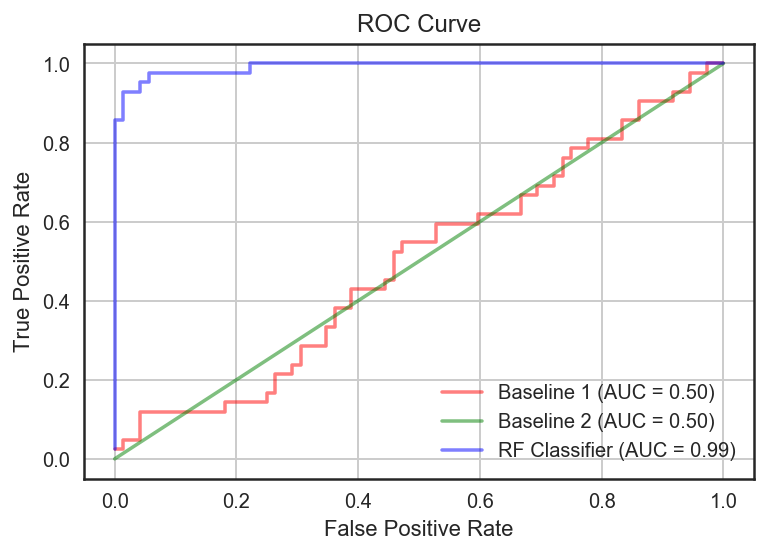

In [39]:
b1_fpr, b1_tpr, b1_roc_th = roc_curve(df_test['target'], df_test['baseline_1_proba'])
b2_fpr, b2_tpr, b2_roc_th = roc_curve(df_test['target'], df_test['baseline_2'])
rf_fpr, rf_tpr, rf_roc_th = roc_curve(df_test['target'], df_test['rf_cls_proba'])
f, ax = plt.subplots()
ax.plot(b1_fpr, b1_tpr, 'r-', alpha=0.5, label='Baseline 1 (AUC = %.2f)' % auc(b1_fpr, b1_tpr))
ax.plot(b2_fpr, b2_tpr, 'g-', alpha=0.5, label='Baseline 2 (AUC = %.2f)' % auc(b2_fpr, b2_tpr))
ax.plot(rf_fpr, rf_tpr, 'b-', alpha=0.5, label='RF Classifier (AUC = %.2f)' % auc(rf_fpr, rf_tpr))
ax.grid(True)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
ax.legend()
f.savefig('images/roc_auc.png', dpi=200, bbox_inches='tight');

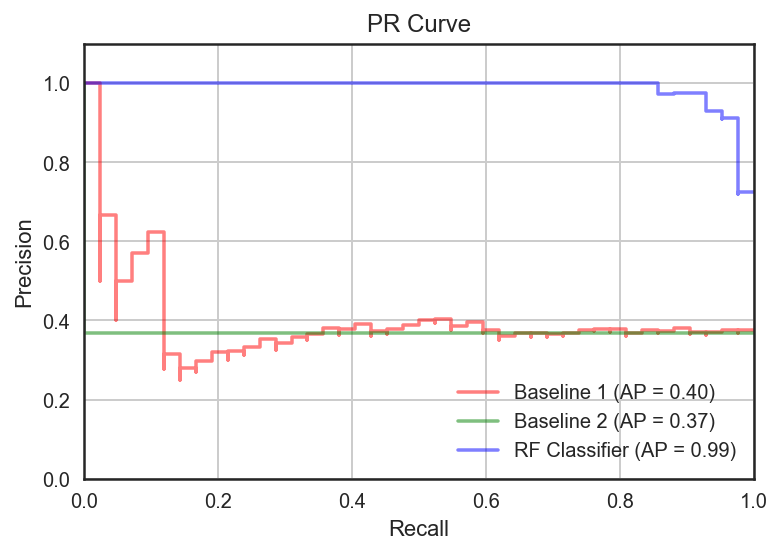

In [40]:
b1_p, b1_r, b1_pr_th = precision_recall_curve(df_test['target'], df_test['baseline_1_proba'])
b1_ap = average_precision_score(df_test['target'], df_test['baseline_1_proba'])
b2_p, b2_r, b2_pr_th = precision_recall_curve(df_test['target'], df_test['baseline_2'])
b2_ap = average_precision_score(df_test['target'], df_test['baseline_2'])
rf_p, rf_r, rf_pr_th = precision_recall_curve(df_test['target'], df_test['rf_cls_proba'])
rf_ap = average_precision_score(df_test['target'], df_test['rf_cls_proba'])
f, ax = plt.subplots()
ax.step(b1_r, b1_p, 'r-', alpha=0.5, label='Baseline 1 (AP = %.2f)' % b1_ap, where='post')
ax.step(b2_r, b2_p, 'g-', alpha=0.5, label='Baseline 2 (AP = %.2f)' % b2_ap, where='post')
ax.step(rf_r, rf_p, 'b-', alpha=0.5, label='RF Classifier (AP = %.2f)' % rf_ap, where='post')
ax.grid(True)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('PR Curve')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.1])
ax.legend()
f.savefig('images/pr_curve.png', dpi=200, bbox_inches='tight');

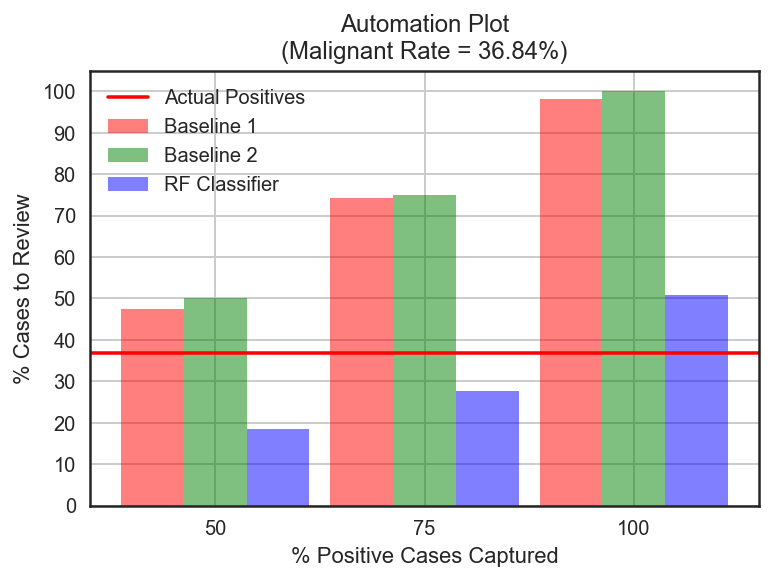

In [61]:
malignant_rate = len(df_test[df_test['target'] == 1]) / len(df_test) * 100
recalls_to_consider = [0.5, 0.75, 1.0]

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx
x = []
b1_auto = []
b2_auto = []
rf_auto = []
for recall in recalls_to_consider:
    x.append(int(recall * 100))
    b1_auto.append(malignant_rate * recall / b1_p[find_nearest(b1_r, recall)[1]])
    b2_auto.append(malignant_rate * recall / b2_p[find_nearest(b2_r, recall)[1]])
    rf_auto.append(malignant_rate * recall / rf_p[find_nearest(rf_r, recall)[1]])

f, ax = plt.subplots()
index = np.arange(len(x))
bar_width = 0.3
opacity = 0.5
ax.bar(index, b1_auto, bar_width,
       alpha=opacity, color='r',
       label='Baseline 1')
ax.bar(index + bar_width, b2_auto, bar_width,
       alpha=opacity, color='g',
       label='Baseline 2')
ax.bar(index + 2 * bar_width, rf_auto, bar_width,
       alpha=opacity, color='b',
       label='RF Classifier')
ax.plot([-0.3, 2.9], [malignant_rate, malignant_rate], 'r-', label='Actual Positives')
ax.set_xlim([-0.3, 2.9])
ax.set_xticks(index + bar_width)
ax.set_xticklabels(x)
ax.set_ylim([0, 105])
ax.set_yticks(np.arange(0, 101, 10))
ax.set_ylabel('% Cases to Review')
ax.set_xlabel('% Positive Cases Captured')
ax.grid(True)
ax.legend()
ax.set_title('Automation Plot\n(Malignant Rate = %.2f%%)' % malignant_rate)
f.savefig('images/automation.png', dpi=200, bbox_inches='tight');